# Dark Current Study
Mauricio Martinez, Brenda Cervantes, Pedro Silves

In [8]:
from functions_py import *
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

sys.path.insert(0, '/home/oem/Software/Serial_Register_Events_Detection')

In [9]:
from ReconLib import *

#### Functions

In [10]:
# Funtions
def hist_RowColumn(data_array):
    Col=np.median(data_array, axis=0)
    #Col=data[10:640,0]#analisis de Registro vertical, Columnas V
    bins_Col=np.histogram_bin_edges(Col, bins='fd')
    Col_hist, bins_Col = np.histogram(Col,bins=bins_Col)
    u_Col, std_Col = norm.fit(Col)
    

    Row=np.median(data_array, axis=1)
    #Row=data[10,10:690] #analisis de Registro horizontal, Renglones H    
    bins_Row=np.histogram_bin_edges(Row, bins='fd')
    Row_hist, bins_Row = np.histogram(Row,bins=bins_Row) 
    u_Row, std_Row = norm.fit(Row)
    

    print('media on Row='+str(u_Row)+', stdDev on y='+str(std_Row))
    print('media on Col='+str(u_Col)+', stdDev on y='+str(std_Col))

    return Row, Col, bins_Row, bins_Col, Row_hist, Col_hist #Row_median, Col_median, bines Row, bines Col, Histogram Row, histogram Col

def line(x, m, b): #data, slope, y-intersection (ordenada al origen)
    return (m*x+b)

def secOrder(x,a,b,c):
    return a*x**2 + b*x + c 

def totTime(path):
    hdul=fits.open(path)# fits file to analyze
    header=hdul[0].header

    tStartList=str(header._cards[159]).split("'")[1].split('T')[1].split(':')
    tEndList=str(header._cards[160]).split("'")[1].split('T')[1].split(':')

    tStart=int(tStartList[0])*3600+int(tStartList[1])*60+int(tStartList[2])
    tEnd=int(tEndList[0])*3600+int(tEndList[1])*60+int(tEndList[2])

    dateStart=header._cards[159][1].split('T')[0]
    dateEnd=header._cards[160][1].split('T')[0]
    if (int(dateEnd.split('-')[-1])-int(dateStart.split('-')[-1])) >0:
        Ttot=tEnd+86400-tStart        # Total time 
    else:
        Ttot=tEnd-tStart        # Total time 

    NRow=int(str(header._cards[15]).split("'")[1])
    NCol=int(str(header._cards[16]).split("'")[1])
    NSamp=int(str(header._cards[17]).split("'")[1])


    deltaTperPix=Ttot/(NCol*NRow)
    deltaTperRow=Ttot/NRow

    expoTimes=[]
    
    for mCol in range(0,NCol):  #Fill Exposure Matrix
        expoTimes.append([])
        for nRow in range(0,NRow):
            expoTimes[mCol].append(deltaTperRow*mCol+deltaTperPix*nRow)


    ExpoMatrix=np.array(expoTimes)
    #NROW650_NCOL700
        
    
    return ExpoMatrix, Ttot, NRow, NCol, NSamp

def exposureFactor(path):
    ExpoMatrix,_,_,_,_=totTime(path)
    fig_all, axs_all = plt.subplots(nrows=1, ncols=2, figsize=(15, 5),constrained_layout=True)		# Create figures
    fig_all.suptitle('Exposure Factor', fontsize='large')
    popt, pcov = curve_fit(line, range(0, len(ExpoMatrix[0])),ExpoMatrix[0]) #ajustar valores de x y yRuido a la funcion "func"
    axs_all[0].set_title('Horizontal')
    axs_all[0].set_ylim([-4, 15])
    axs_all[0].set_ylabel('Exposure time [s]')
    axs_all[0].set_xlabel('Col')
    axs_all[1].set_xlabel('Row')
    axs_all[0].plot(range(0,len(ExpoMatrix[0])), line(range(0,len(ExpoMatrix[0])), popt[0], popt[1]),'r-', label='fit: m=%f [s/pix], b=%f' % tuple(popt))
    HEF=popt[0] #Horizontal exposure factor
    axs_all[0].legend()
    popt, pcov = curve_fit(line, range(0, len(ExpoMatrix[:,0])),ExpoMatrix[:,0])
    axs_all[1].set_title('Vertical')
    axs_all[1].plot(range(0,len(ExpoMatrix[:,0])), line(range(0,len(ExpoMatrix[:,0])), popt[0], popt[1]),'b-', label='fit by column: m=%f [s/pix], b=%f' % tuple(popt))
    VEF=popt[0] #Vertical Exposure Factor
    axs_all[1].legend()
    plt.show()
    return HEF, VEF

def sum_intensity(region, intensities):
    return np.sum(intensities[region])




#### Format of images

In [11]:
plt.rcParams.update({
    "image.origin": "lower",
    "image.aspect": 1,
    #"text.usetex": True,
    "grid.alpha": .5,
    "axes.linewidth":2,
    "lines.linewidth" : 1,
    "font.size":    15.0,
    "xaxis.labellocation": 'right',  # alignment of the xaxis label: {left, right, center}
    "yaxis.labellocation": 'top',  # alignment of the yaxis label: {bottom, top, center}
    "xtick.top":           True ,  # draw ticks on the top side
    "xtick.major.size":    8    ,# major tick size in points
    "xtick.minor.size":    4      ,# minor tick size in points
    "xtick.direction":     'in',
    "xtick.minor.visible": True,
    "ytick.right":           True ,  # draw ticks on the top side
    "ytick.major.size":    8    ,# major tick size in points
    "ytick.minor.size":    4      ,# minor tick size in points
    "ytick.direction":     'in',
    "ytick.minor.visible": True,
    "ytick.major.width":   2   , # major tick width in points
    "ytick.minor.width":   1 ,
    "xtick.major.width":   2   , # major tick width in points
    "xtick.minor.width":   1 ,
    "legend.framealpha": 0 ,
    "legend.loc": 'best',

})

# Microchip images

## Raw Image

Filename: /home/oem/datosFits/spuriousCharge/Microchip/14AUG23/proc_skp_module24_MITLL01_externalVr-4_Vv2_T140__NSAMP225_NROW650_NCOL700_EXPOSURE0_NBINROW1_NBINCOL1_img109.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     165   (700, 650)   float32   
  1                1 ImageHDU       164   (700, 650)   float32   
  2                1 ImageHDU       164   (700, 650)   float32   
  3                1 ImageHDU       164   (700, 650)   float32   
None
----------------


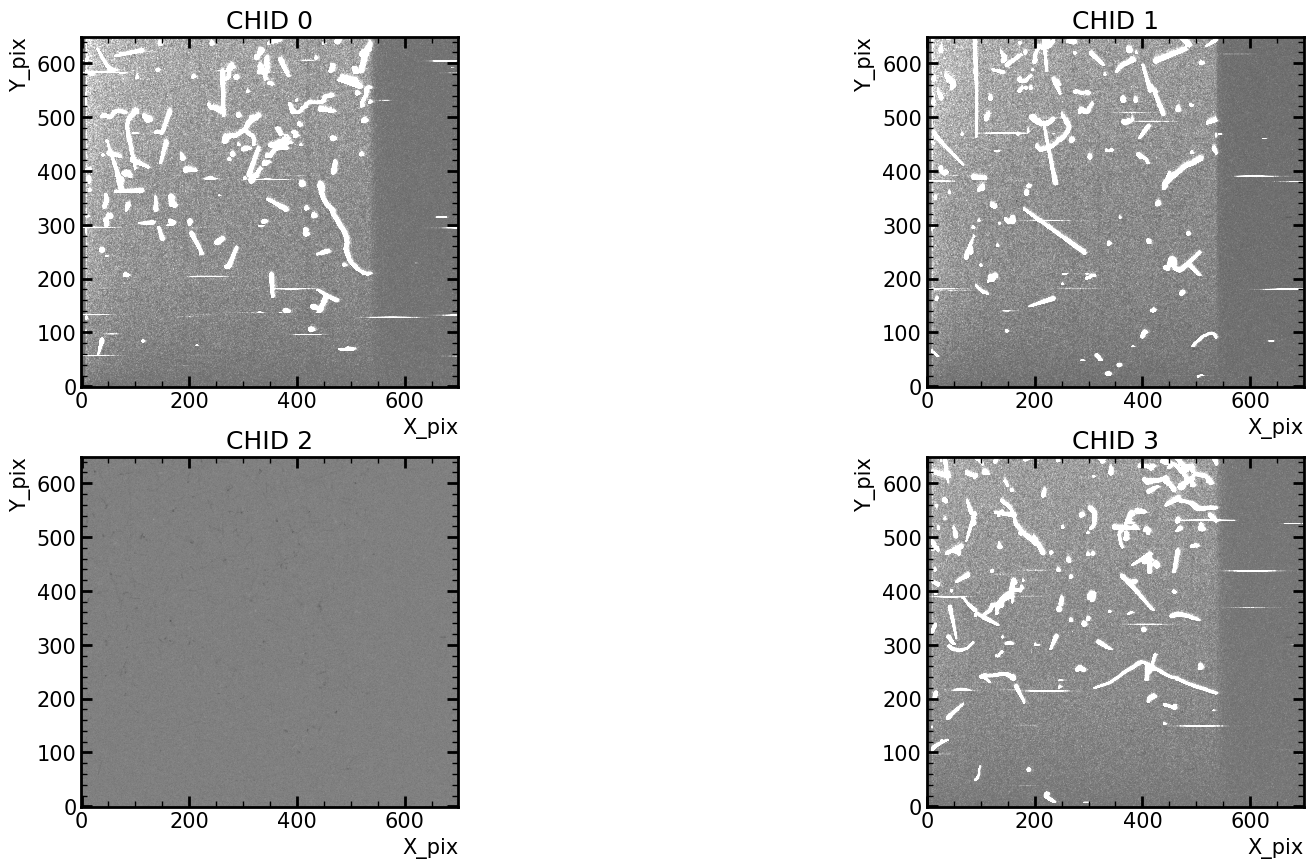

In [12]:
path='/home/oem/datosFits/spuriousCharge/Microchip/14AUG23/proc_skp_module24_MITLL01_externalVr-4_Vv2_T140__NSAMP225_NROW650_NCOL700_EXPOSURE0_NBINROW1_NBINCOL1_img109.fits'
hdu_list = fits.open(path)
print(hdu_list.info())
print('----------------')
# hdu_list[0].header
plt.figure(figsize=(20,10))
for i in range(4):
    plt.subplot(2,2,i+1)
    plt.imshow(hdu_list[i].data-np.median(hdu_list[i].data),vmin=-800,vmax=800,cmap='gray')
    plt.title('CHID '+str(i))
    plt.ylabel('Y_pix')
    plt.xlabel('X_pix')
plt.show()

### Before Calibrate

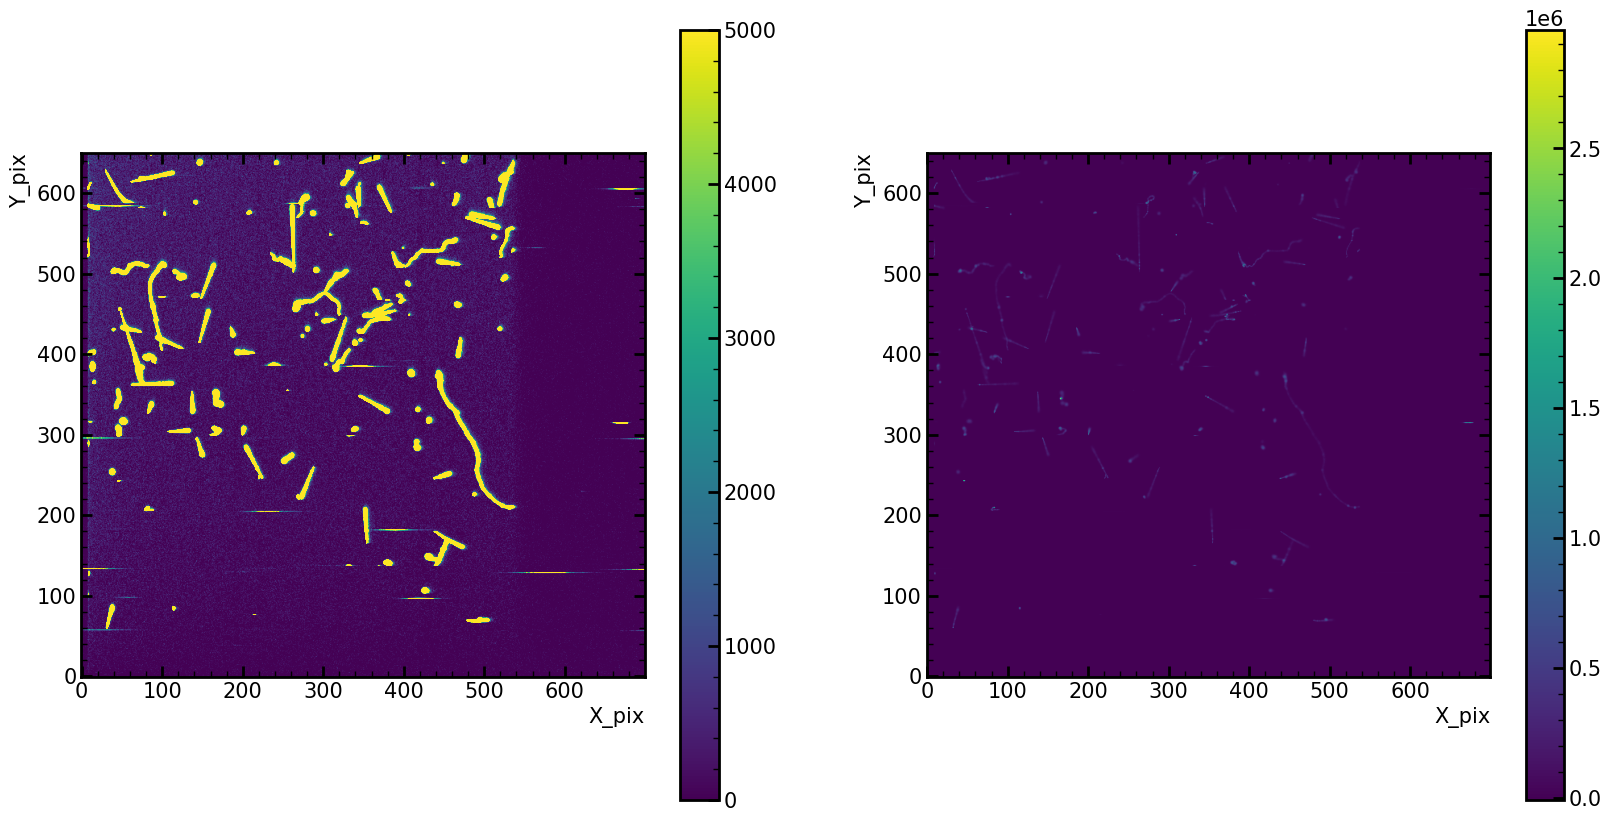

In [13]:
Plot2Images(hdu_list[0].data, hdu_list[0].data, MaxRange=5000,MinRange=0) #data and data with max and min defined
#PlotImage(hdu_list[0].data)

In [14]:
serialRegisterEvents_n25, _, _, _   =  makeSerialRegisterEventAdvancedMask(hdu_list[0].data,n = 2.5)
serialRegisterEvents_n3, _, _, _    =  makeSerialRegisterEventAdvancedMask(hdu_list[0].data,n = 3)
serialRegisterEvents_n35, _, _, _   =  makeSerialRegisterEventAdvancedMask(hdu_list[0].data,n = 3.5)
serialRegisterEvents_n4, _, _, _    =  makeSerialRegisterEventAdvancedMask(hdu_list[0].data,n = 4)
serialRegisterEvents_n5, CCDMask, _, _=makeSerialRegisterEventAdvancedMask(hdu_list[0].data,n = 5)

In [15]:
serialRegisterEvents_n55, _, _, _   =  makeSerialRegisterEventAdvancedMask(hdu_list[0].data,n = 5.5)
serialRegisterEvents_n6, _, _, _    =  makeSerialRegisterEventAdvancedMask(hdu_list[0].data,n = 6)
serialRegisterEvents_n65, _, _, _   =  makeSerialRegisterEventAdvancedMask(hdu_list[0].data,n = 6.5)
serialRegisterEvents_n7, _, _, _    =  makeSerialRegisterEventAdvancedMask(hdu_list[0].data,n = 7)
serialRegisterEvents_n75, CCDMask, _, _=makeSerialRegisterEventAdvancedMask(hdu_list[0].data,n = 7.5)

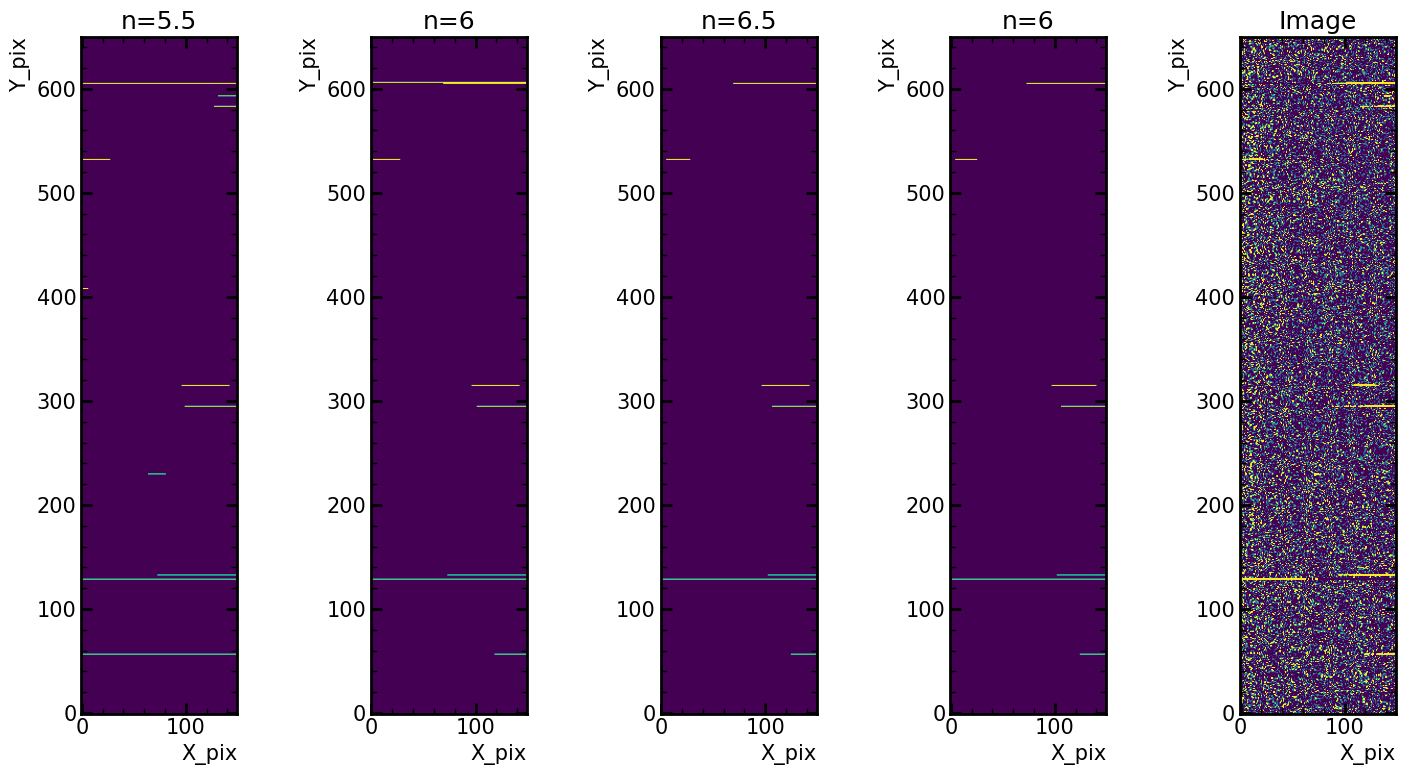

In [44]:
#OS_comparison(serialRegisterEvents_n25[:,550:],serialRegisterEvents_n3[:,550:],serialRegisterEvents_n35[:,550:],serialRegisterEvents_n4[:,550:],hdu_list[0].data[:,550:] ,colorBar_1=False, MaxRange=100, titleImage=[1,2,3,4])
OS_comparison(serialRegisterEvents_n25,serialRegisterEvents_n3,serialRegisterEvents_n35,serialRegisterEvents_n4,hdu_list[0].data,colorBar_1=False, MaxRange=100, titleImage=['5.5','6','6.5','6'])

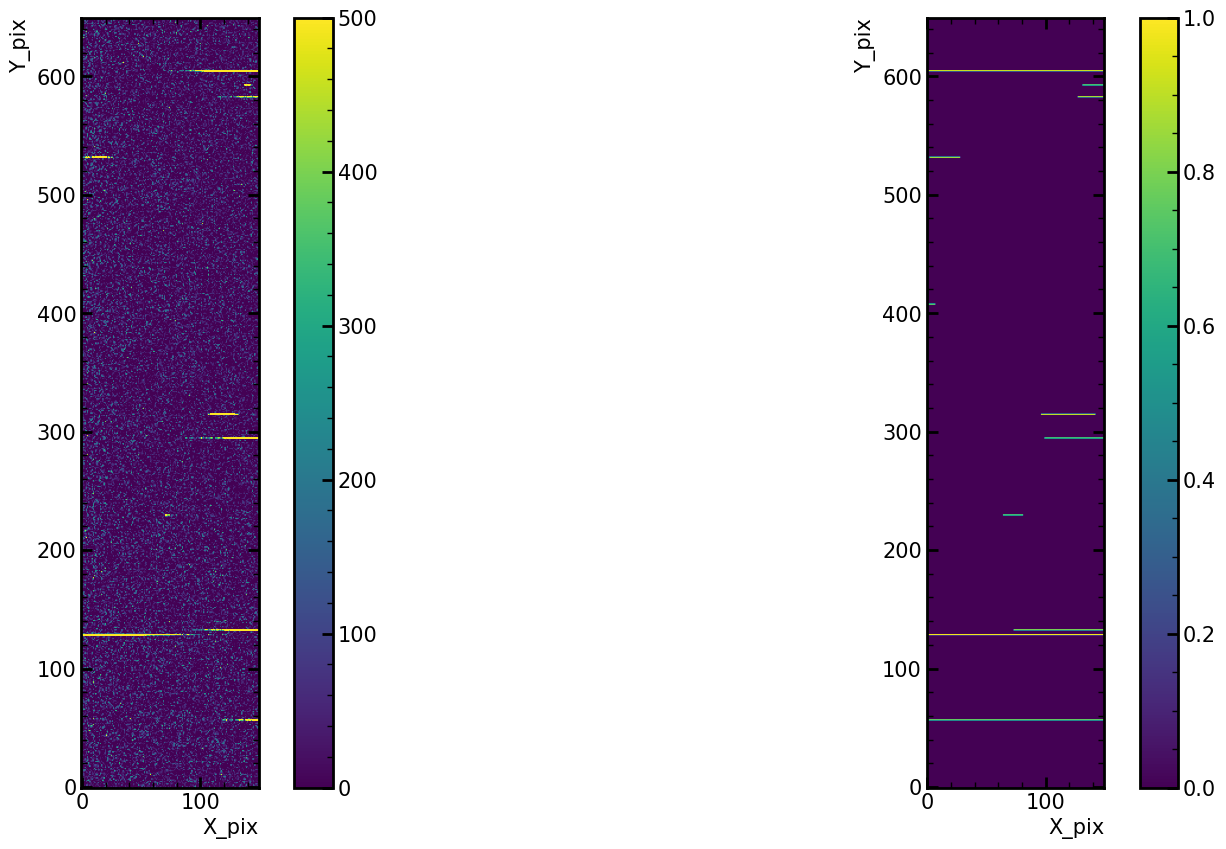

In [18]:
Plot2Images(hdu_list[0].data[:,550:],serialRegisterEvents_n25[:,550:],MaxRange=500,MinRange=0)

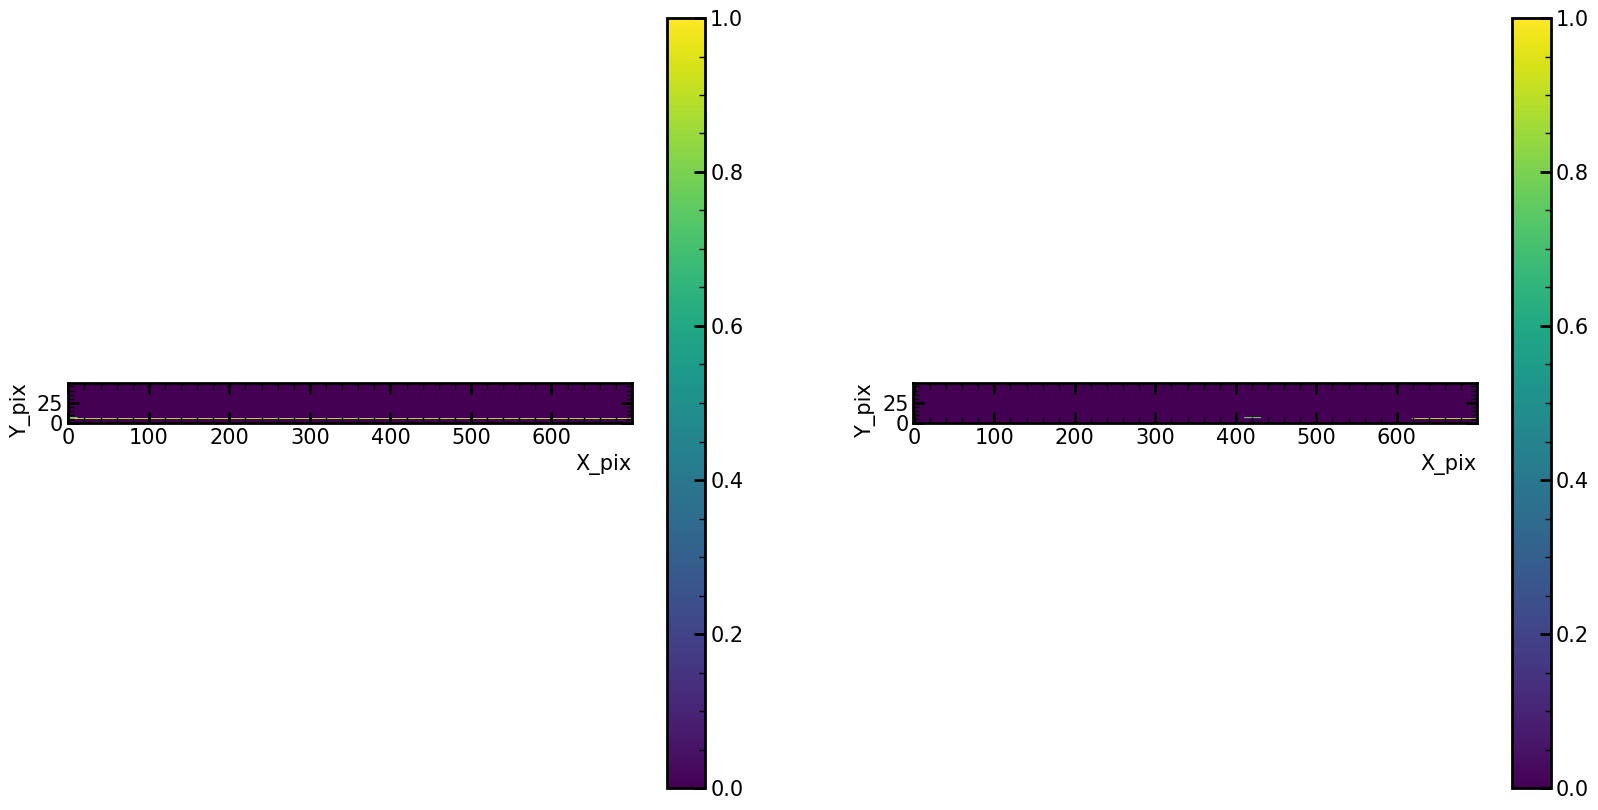

In [19]:
Plot2Images(serialRegisterEvents_n25[600:,:],serialRegisterEvents_n35[600:,:])

In [20]:
la_mascara=ma.masked_array(hdu_list[0].data, mask=serialRegisterEvents_n3)



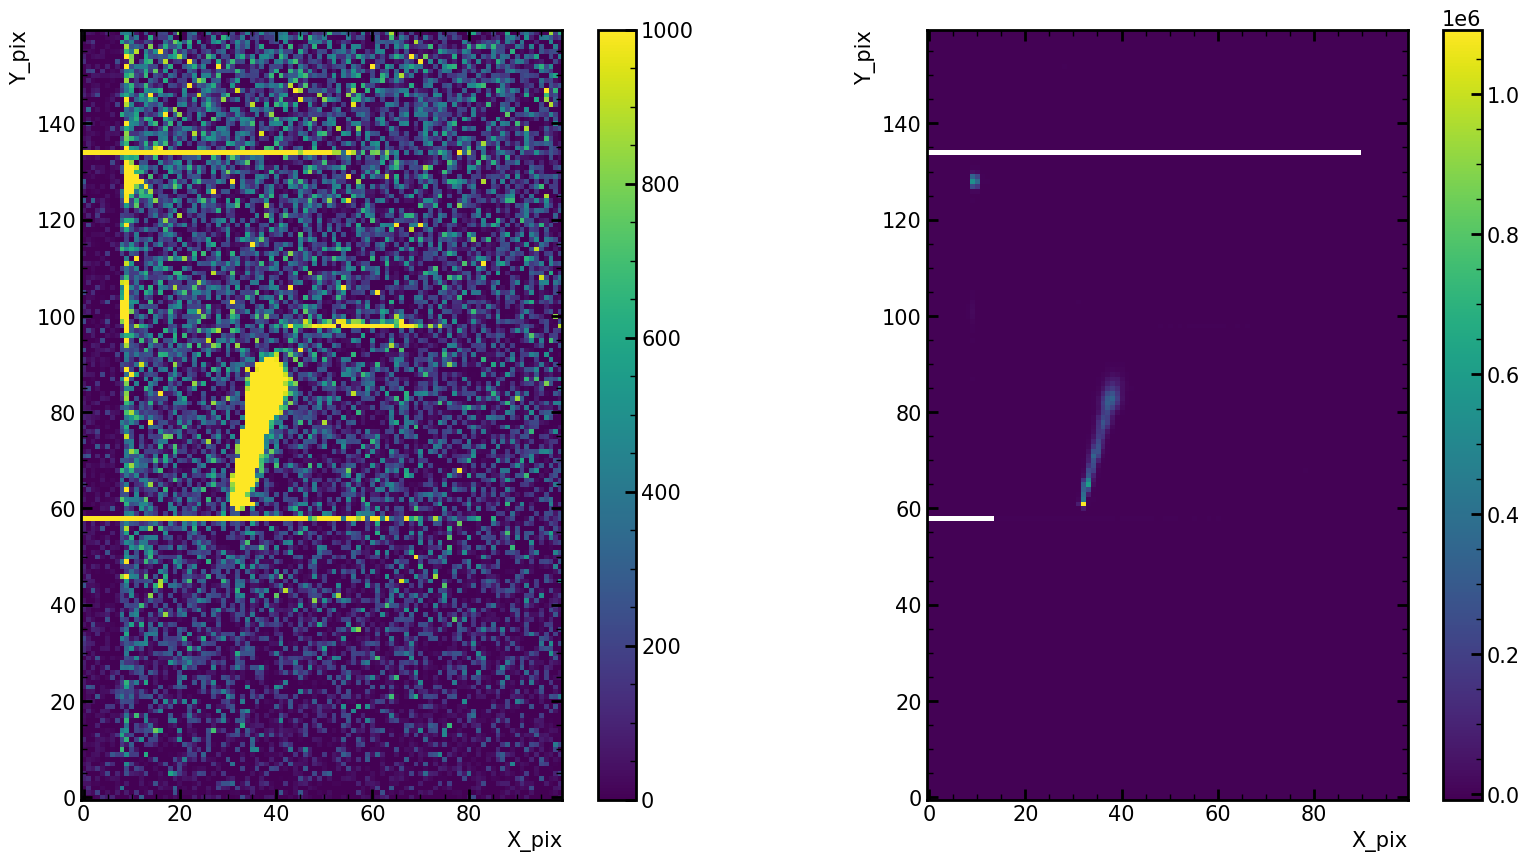

In [21]:
Plot2Images(hdu_list[0].data[0:160,0:100], la_mascara[0:160,0:100],MinRange=0, MaxRange=1000)

### Calibrate image

In [22]:
nsamp=int(hdu_list[0]._header.cards._header.cards._header._cards[17].image.split("'")[1])
if nsamp > 200:
    data_pre = precal(hdu_list,extensions=4)
    gain, gain_err, data= LocalCalib(data_pre,extensions=4)
else:
    data = hdu_list[i].data
    gain=[200,200,200,200]
    gain_err=[0,0,0,0]
    for extension in len(data):
        data[extension]=data[extension]/gain[extension]
    




[32.84776057]
[26.83791537]
Error - Xtalk fit failed on local calib


CHID 0 Gain:(220.09 +- 1.46)ADUs
CHID 1 Gain:(217.91 +- 1.50)ADUs
CHID 2 Gain:(172.96 +- 138.90)ADUs
CHID 3 Gain:(201.27 +- 1.22)ADUs


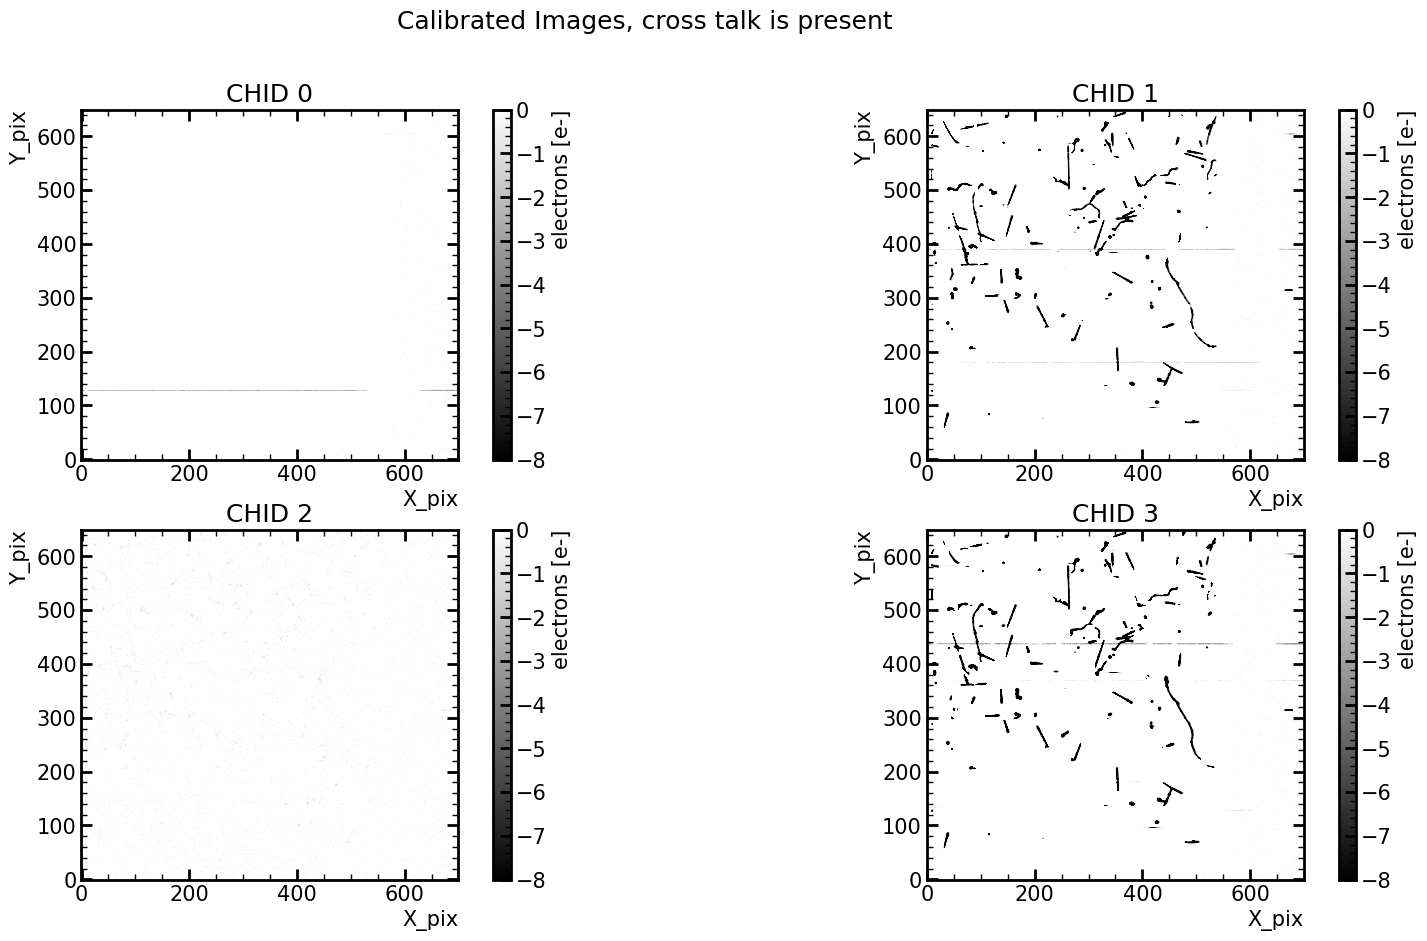

In [23]:
fig=plt.figure(figsize=(20,10))
for i in range(4):
    plt.subplot(2,2,i+1)
    im=plt.imshow(data[i],vmin=-8,vmax=-0, cmap='gray')
    plt.title('CHID '+str(i))
    plt.ylabel('Y_pix')
    plt.xlabel('X_pix')
    print("CHID "+str(i)+' Gain:({:.2f} +- {:.2f})ADUs'.format(gain[i],gain_err[i]))
    cbar=fig.colorbar(im)
    cbar.set_label('electrons [e-]')
    


plt.suptitle('Calibrated Images, cross talk is present')

#plt.savefig('IMAGES_POSCALIB.png', bbox_inches='tight', dpi=100)
    
plt.show()


In [24]:
electron_threshold=-1  # [e-]  electrons

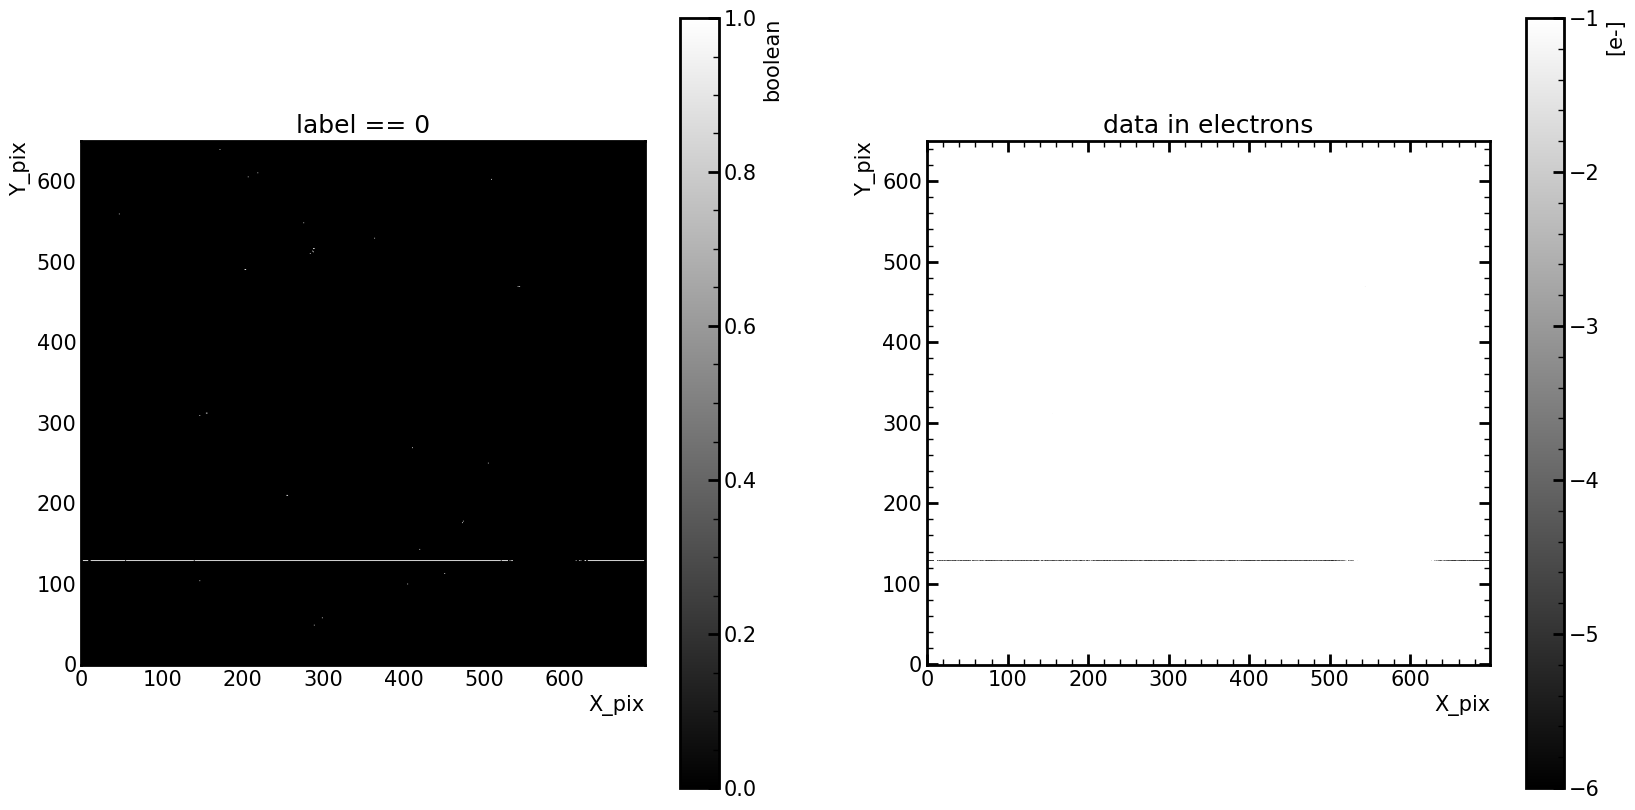

In [25]:
label=ndimage.label(data[0]>electron_threshold,structure=[[1,1,1],[1,1,1],[1,1,1]])[0]
fig=plt.figure(figsize=(20,10))

plt.subplot(1,2,1)
plt.title('label == 0') #events under electron threshold
plt.ylabel('Y_pix')
plt.xlabel('X_pix')

im=plt.imshow(label==0, cmap='gray')
cbar=fig.colorbar(im)
cbar.set_label('boolean')

plt.subplot(1,2,2)
plt.title('data in electrons')  
plt.ylabel('Y_pix')
plt.xlabel('X_pix')
im=plt.imshow(data[0], cmap='gray', vmax=electron_threshold, vmin=-6)
cbar=fig.colorbar(im)
cbar.set_label('[e-]')

-0.9963208569486073

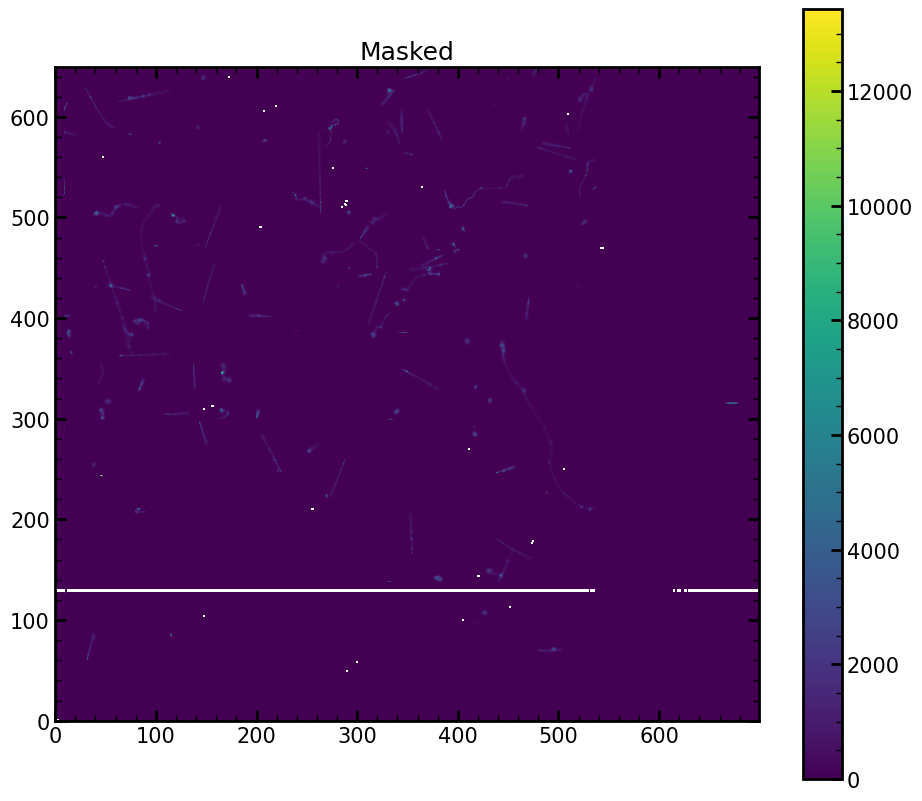

In [26]:
fig=plt.figure(figsize=(25,10))

plt.subplot(1,2,1)
plt.title('Masked')

y=np.ma.array(label==0)  #  "y" es la mascaraa, los eventos son "1"s y lo demas "0"s

maskedData=ma.masked_array(data[0], mask=y)
maskedPlot=plt.imshow(maskedData)#, vmin=maskedData.min())#, vmax=maskedData.max())
cbar=fig.colorbar(maskedPlot)
maskedData.max()
maskedData.min()

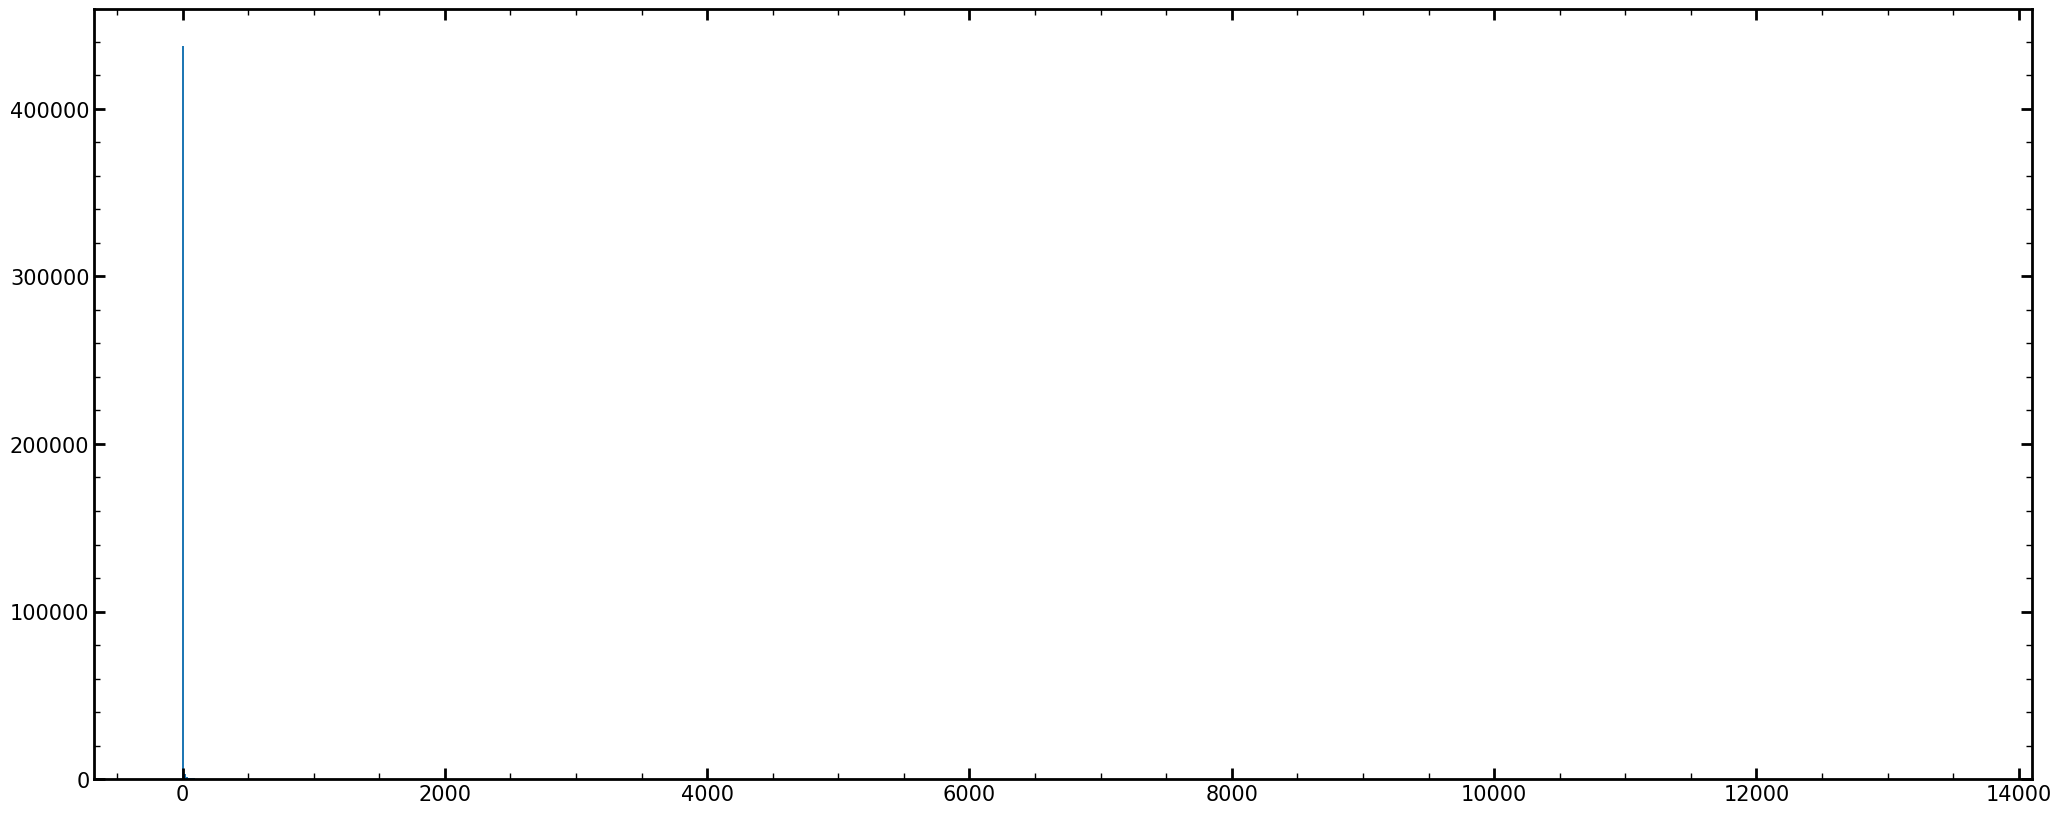

In [27]:
fig=plt.figure(figsize=(25,10))
histograma=plt.hist(maskedData.flatten(), bins=1000, log=False)# range=(maskedData.min(),maskedData.max()), log=True)

-0.9963208569486073

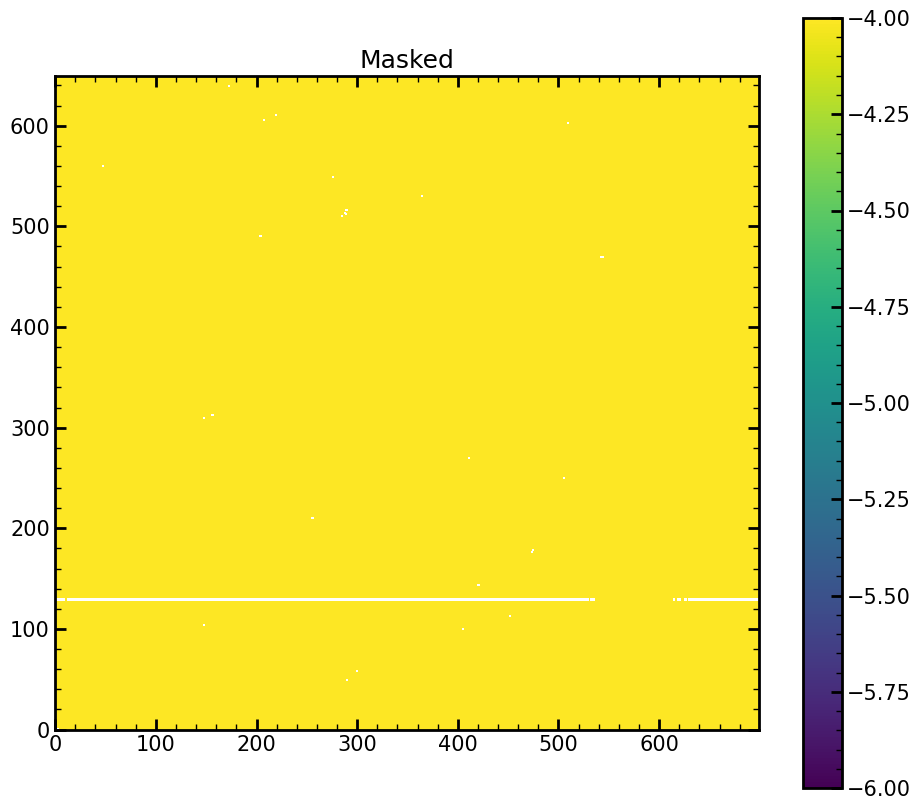

In [28]:
fig=plt.figure(figsize=(25,10))

plt.subplot(1,2,1)
plt.title('Masked')

y=np.ma.array(label==0)  #  "y" es la mascaraa, los eventos son "1"s y lo demas "0"s

maskedData=ma.masked_array(data[0], mask=y)
maskedPlot=plt.imshow(maskedData, vmin=-6, vmax=-4)
cbar=fig.colorbar(maskedPlot)
maskedData.max()
maskedData.min()

In [29]:
mascara = makeSerialRegisterEventMask(data[0],n=3,extend=True)

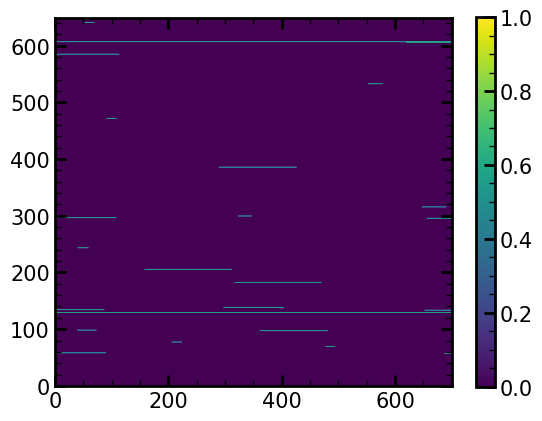

In [30]:
PlotImage(mascara[0])

-0.9963208569486073

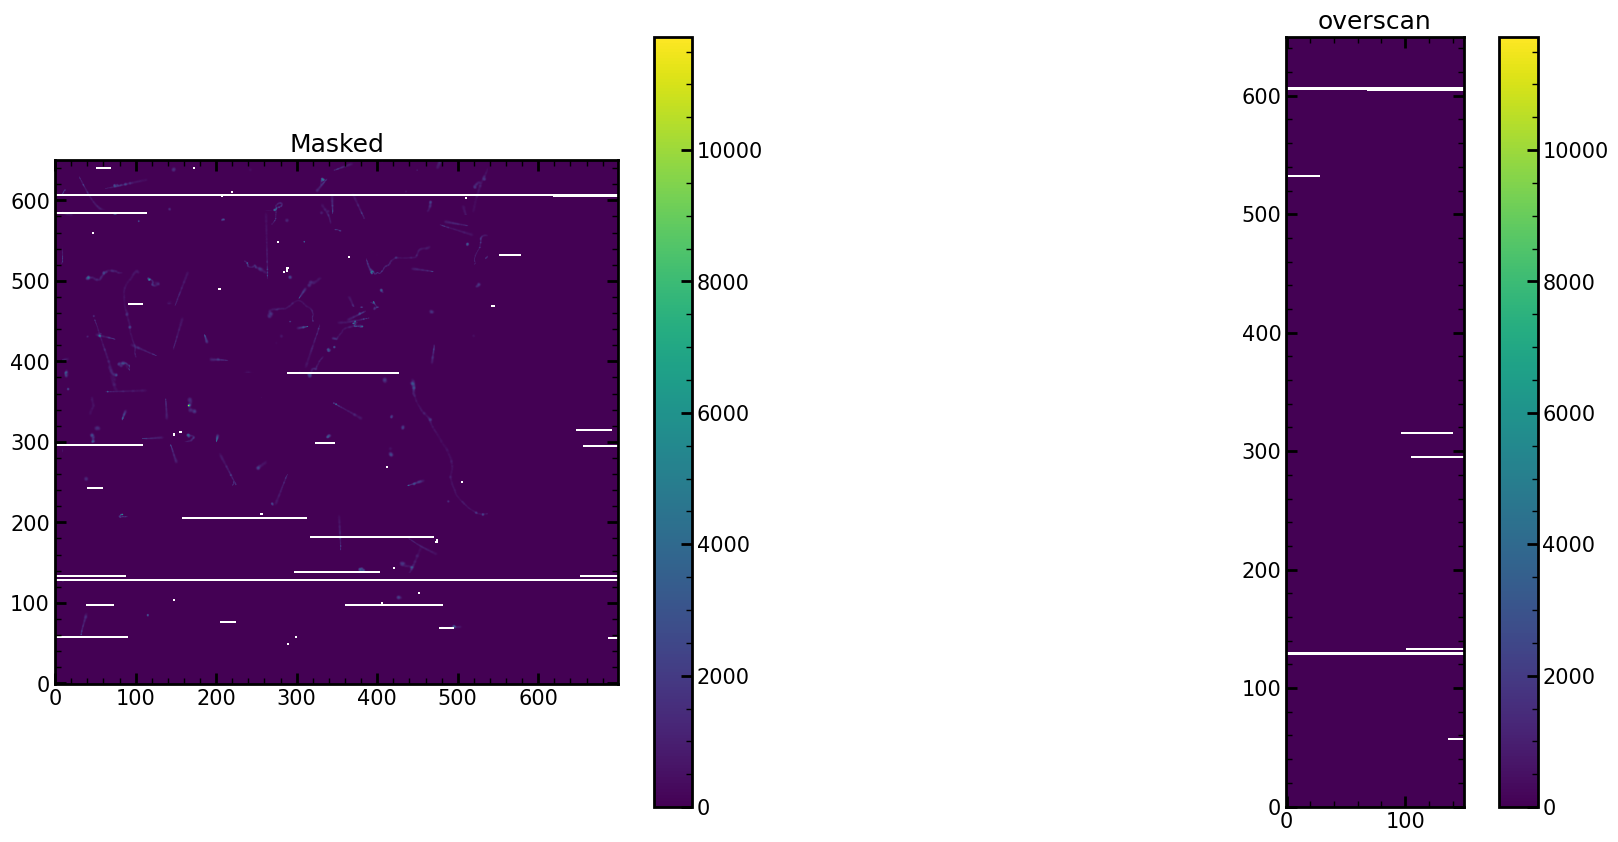

In [31]:
fig=plt.figure(figsize=(20,10))

plt.subplot(1,2,1)
plt.title('Masked')

y=np.ma.array(label==0)  #  "y" es la mascaraa, los eventos son "1"s y lo demas "0"s

maskedData=ma.masked_array(data[0], mask=mascara[0]+ y)
maskedPlot=plt.imshow(maskedData, vmin=maskedData.min(), vmax=maskedData.max())

cbar=fig.colorbar(maskedPlot)
maskedData.max()
maskedData.min()

plt.subplot(1,2,2)
plt.title('overscan')
overScanPlot=plt.imshow(maskedData[:,550:], vmin=maskedData.min(), vmax=maskedData.max())

cbar=fig.colorbar(overScanPlot)
maskedData.max()
maskedData.min()




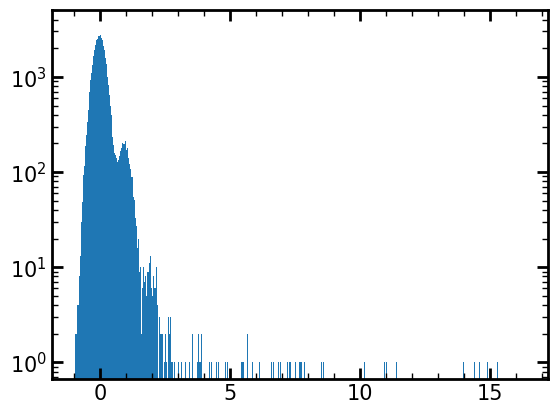

In [32]:
histograma=plt.hist(maskedData[:,550:].flatten(), bins=1000, range=(maskedData[:,550:].min(),maskedData[:,550:].max()), log=True)

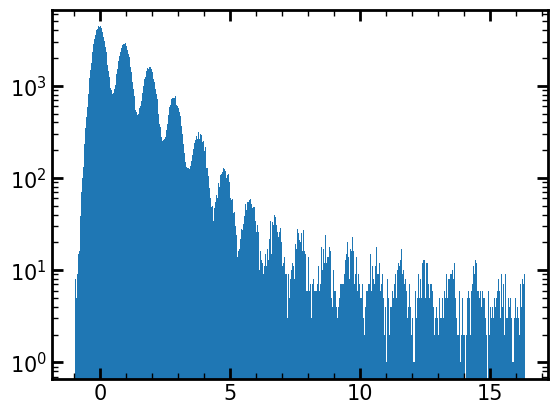

In [33]:
histograma=plt.hist(maskedData[:,:550].flatten(), bins=1000, range=(maskedData[:,550:].min(),maskedData[:,550:].max()), log=True)

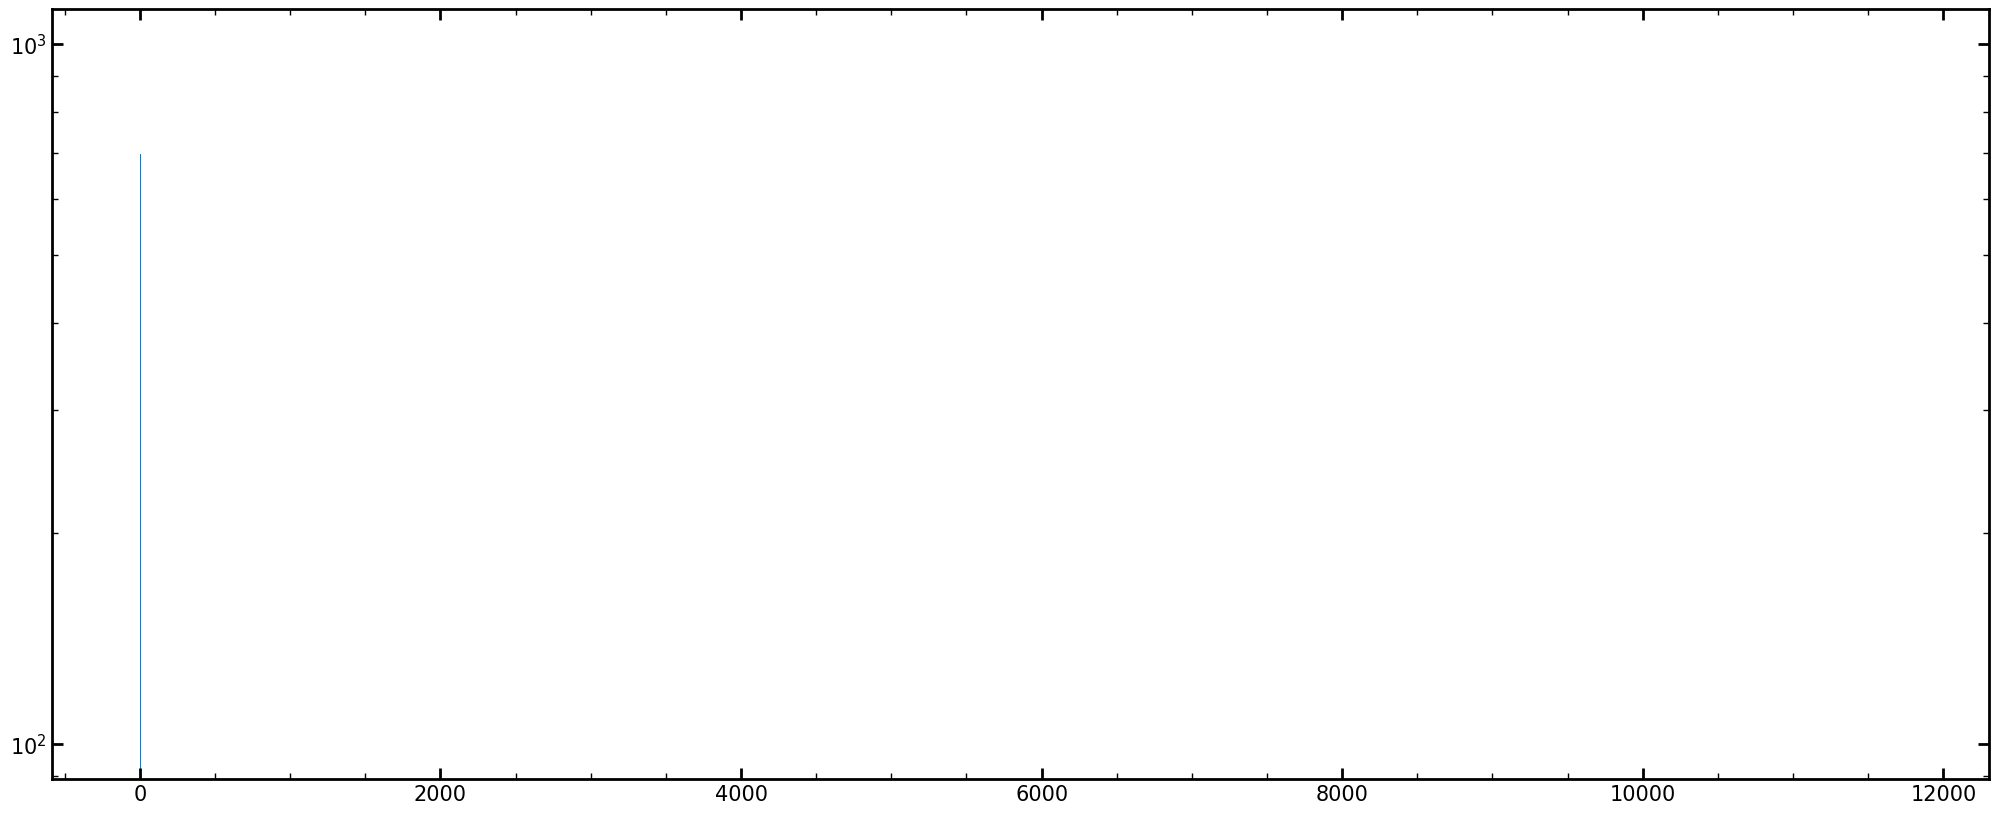

In [34]:
fig=plt.figure(figsize=(25,10))
histograma=plt.hist(maskedData[0].flatten(), bins=1000, range=(maskedData.min(),maskedData.max()), log=True)

In [35]:
maskedData[0].min()

-0.7153042278429691

5090

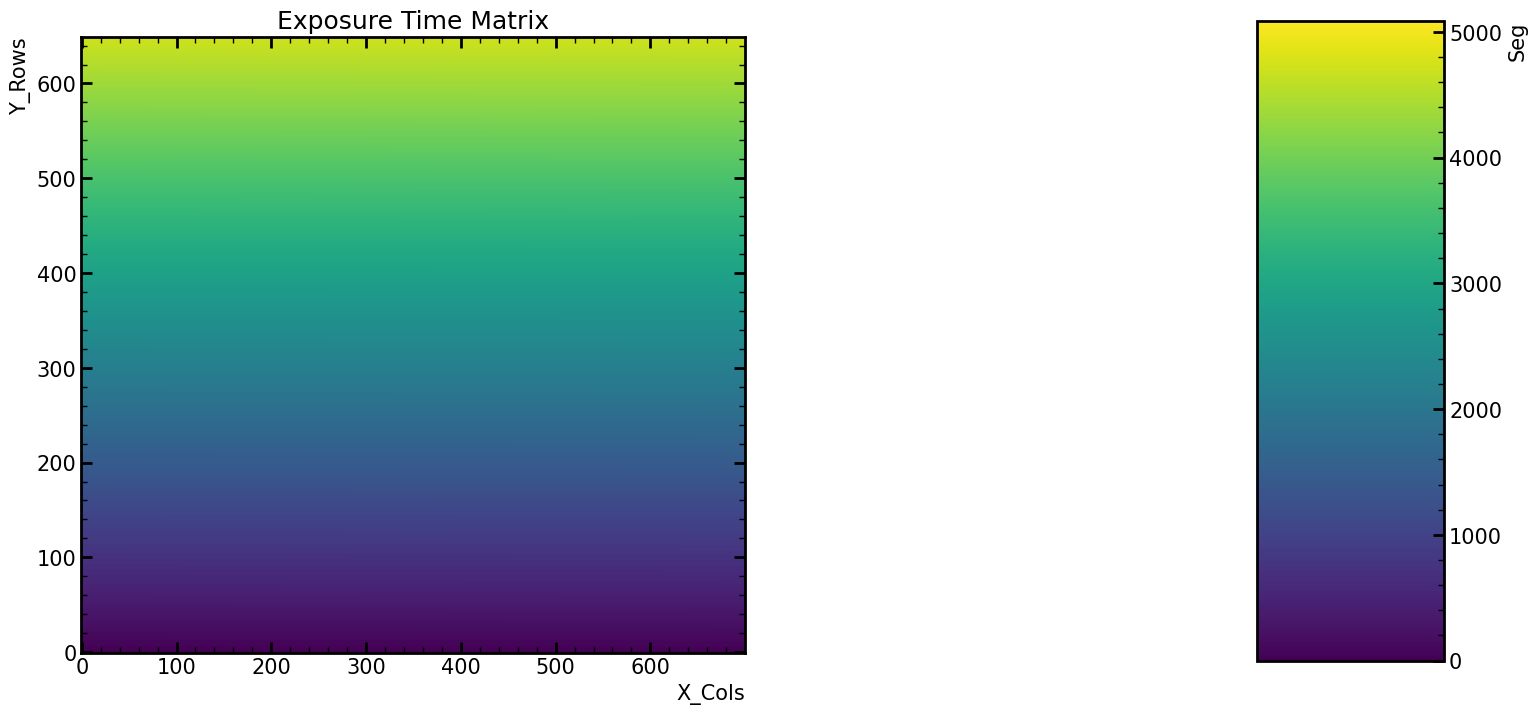

In [36]:
ExpoMatrix, Ttot, NRow, NCol, NSamp= totTime(path)
fig=plt.figure(figsize=(25,8))
plt.imshow(ExpoMatrix,vmin=0,vmax=Ttot)


plt.title('Exposure Time Matrix')
plt.ylabel('Y_Rows')
plt.xlabel('X_Cols')

cax = plt.axes([0.85, 0.1, 0.075, 0.8])
plt.colorbar(cax=cax)
plt.ylabel('Seg')

#ExpoMatrix
Ttot

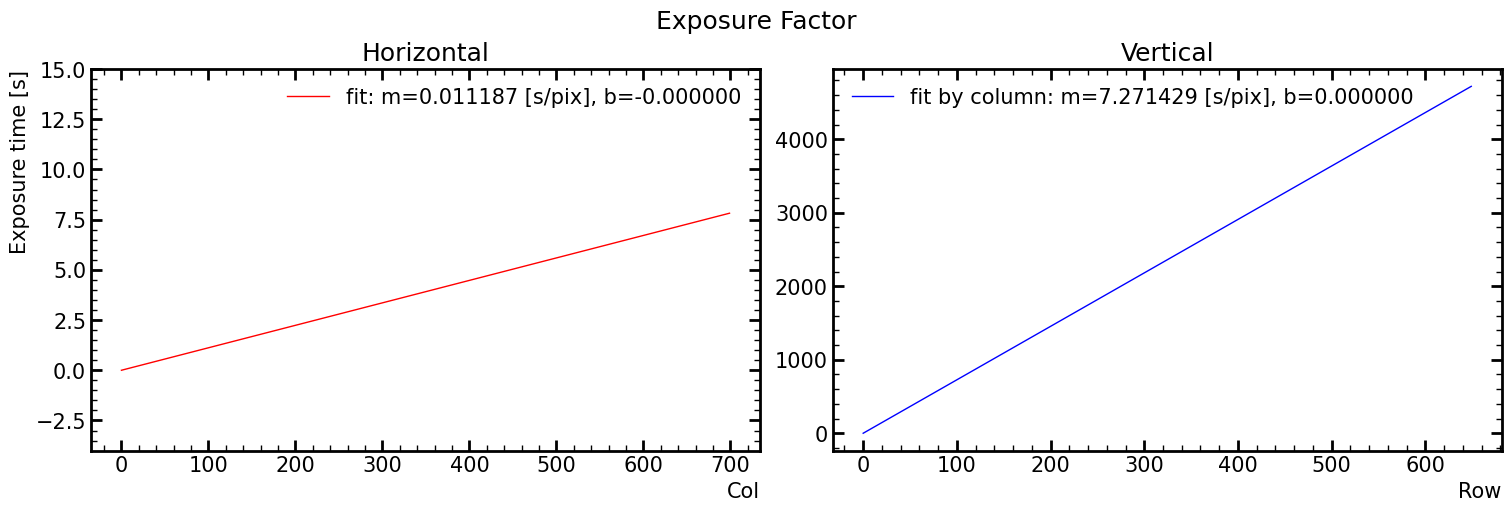

In [37]:
HEF, VEF = exposureFactor(path) #Exposure Factor in [s/pix]

media on Row=0.32980655697016387, stdDev on y=0.442830275246575
media on Col=0.4451707560551274, stdDev on y=0.28558411700221065


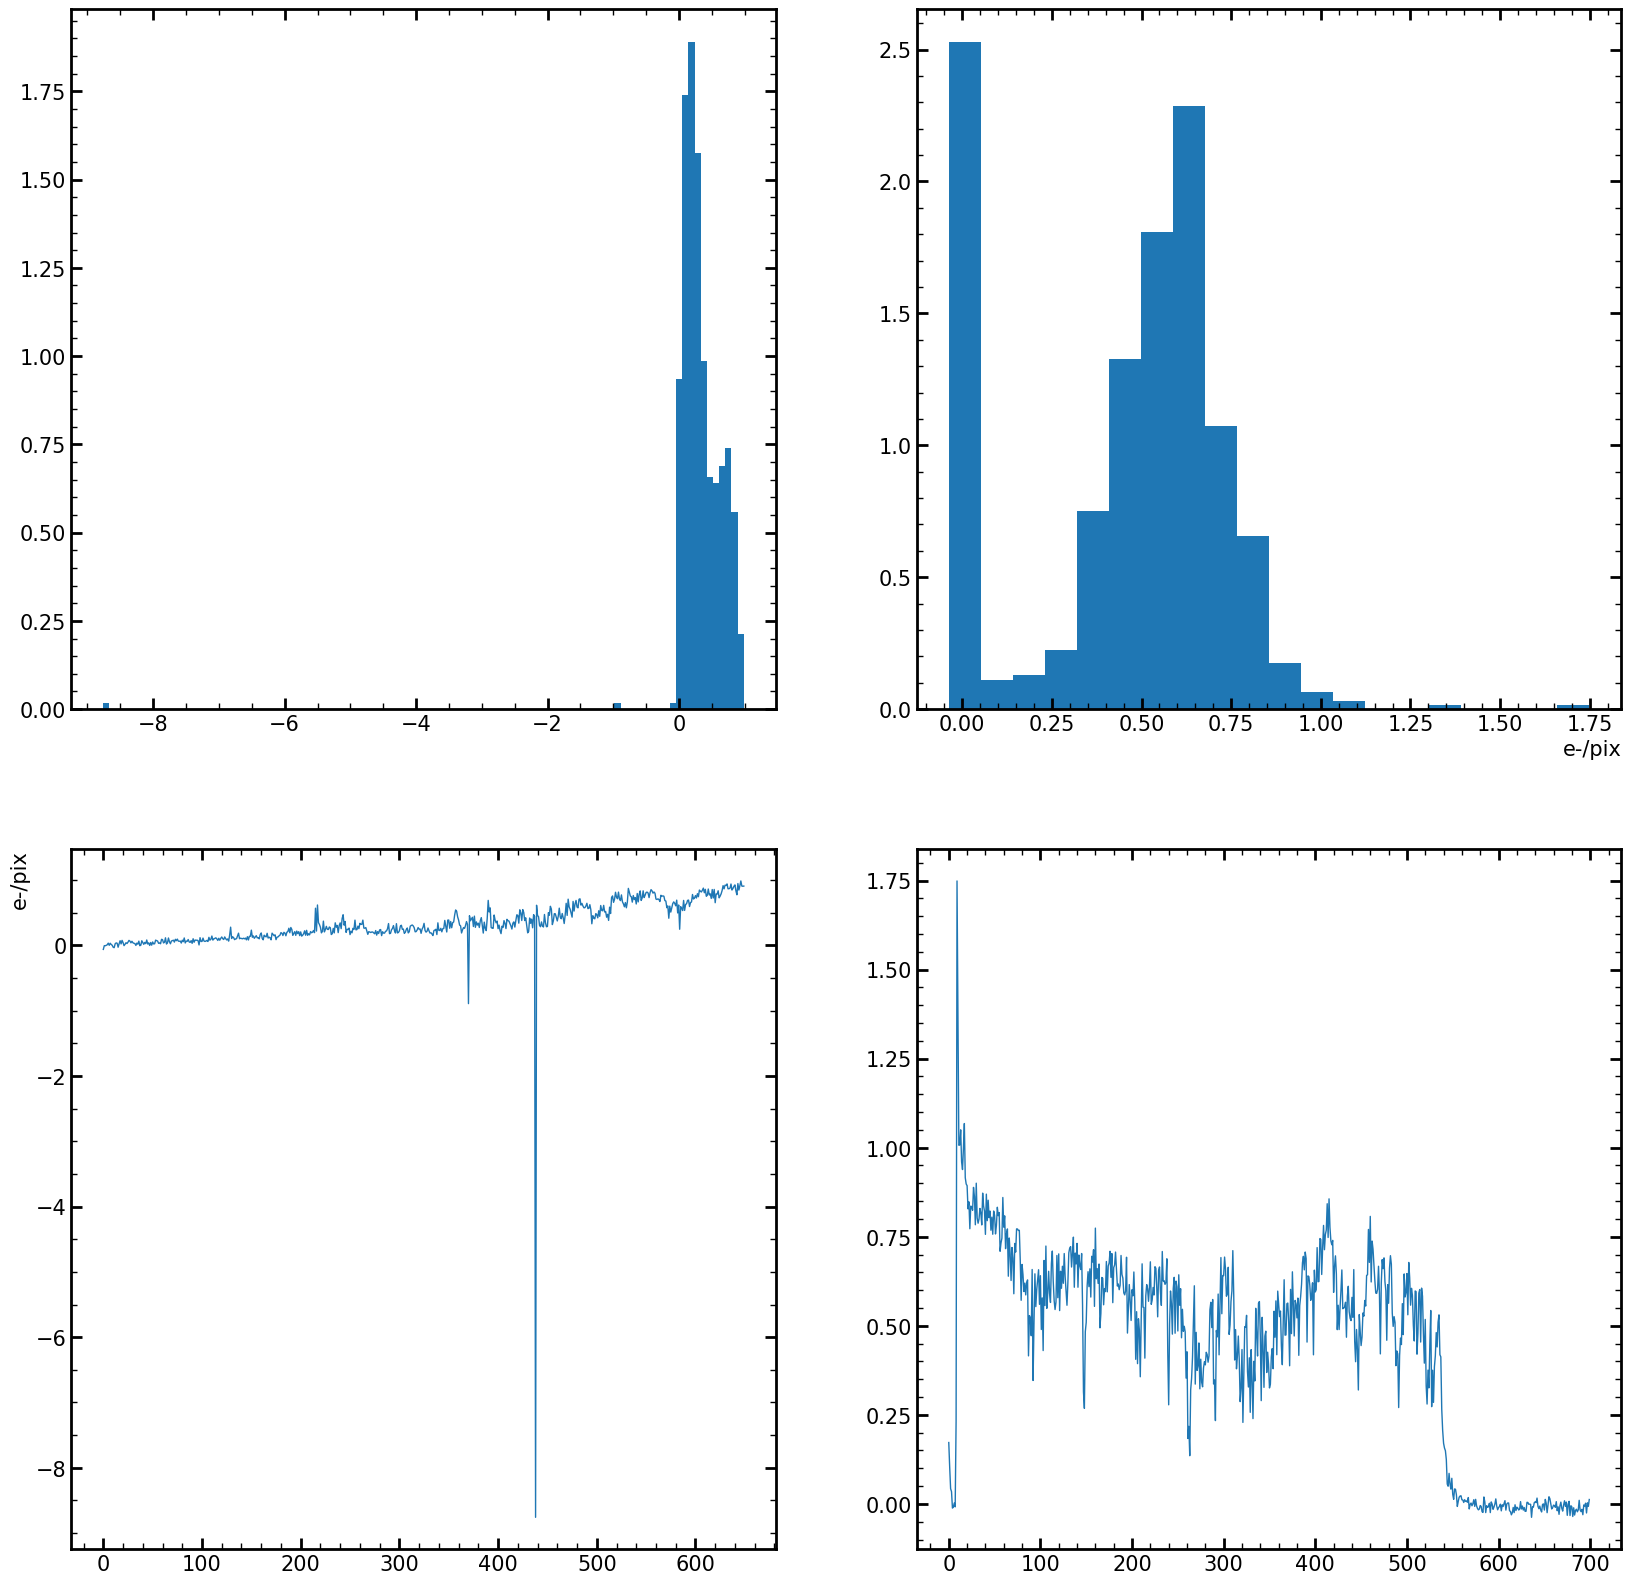

In [38]:
data_masked=data[3]#hdu_list[1].data#-1e7*(maskV_bleeding+mask_bleeding+SRE_mask)

data_Row, data_Col, Row_bins, Col_bins, Row_hist, Col_hist = hist_RowColumn(data_masked)

fig_all, axs_all = plt.subplots(2, 2, figsize=(20, 20))		# Create figures


axs_all[0][0].hist(data_Row, Row_bins, density=True)

axs_all[0][1].hist(data_Col, Col_bins, density=True)

axs_all[1][0].plot(data_Row)

axs_all[1][1].plot(data_Col)

axs_all[1][0].set_ylabel('e-/pix')
axs_all[0][1].set_xlabel('e-/pix')

plt.show()


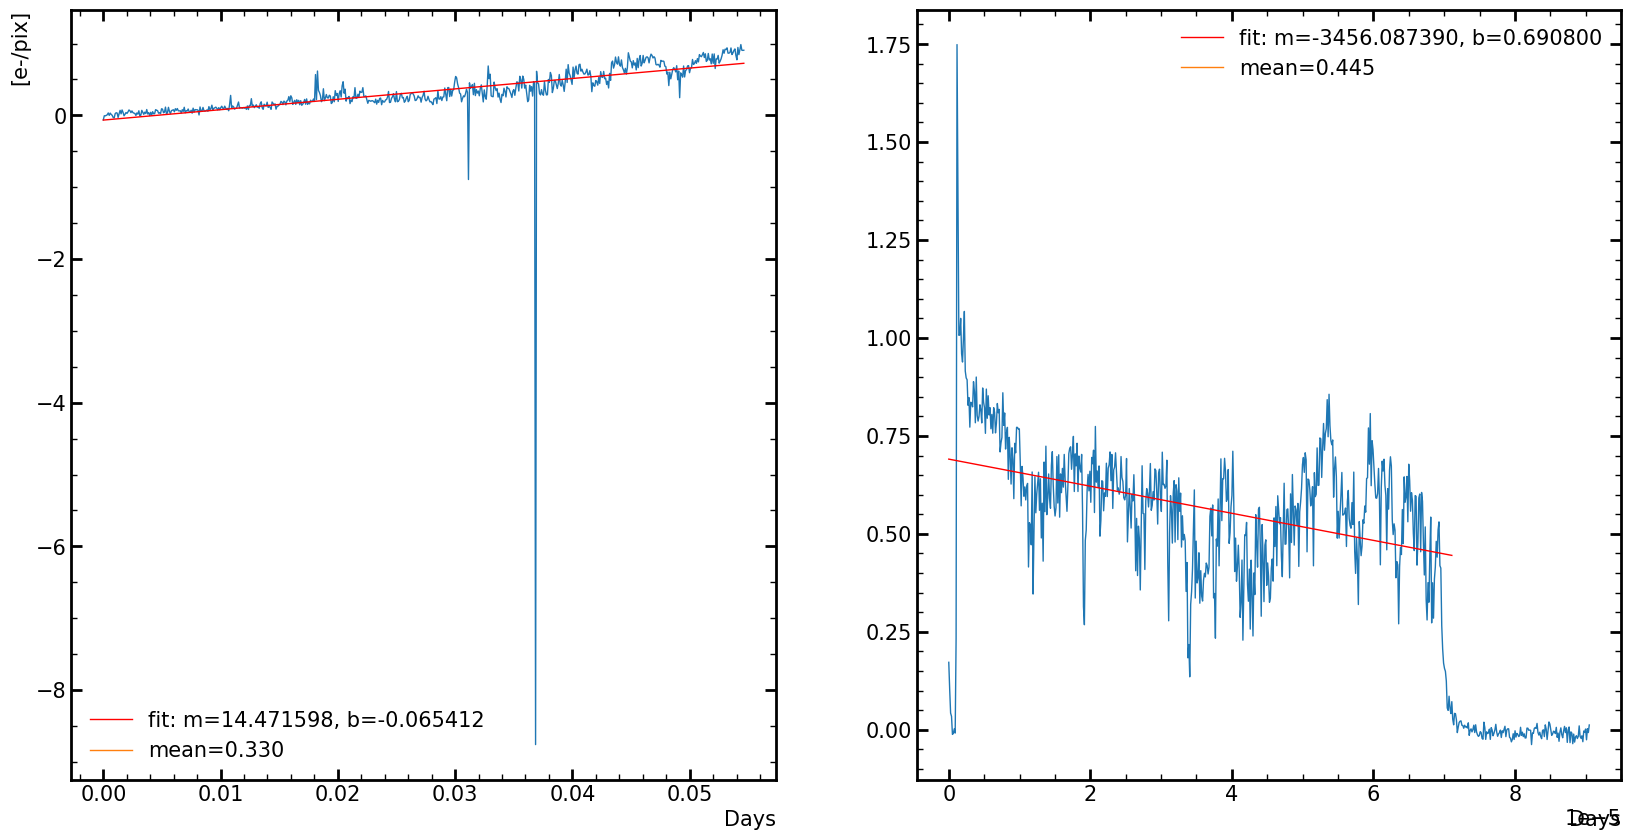

In [39]:
#NROW650_NCOL700
fig_all, axs_all = plt.subplots(1, 2, figsize=(20, 10))		# Create figures
x_data=[]
i=0

for value in data_Row:  
            x_data.append(i)
            i+=1
Xdata=np.array(x_data)*VEF/86400

axs_all[0].plot(Xdata, data_Row) #Xdata[Pix]*VEF[S/Pix], data_Row[e-]*86400[s/day]/VEF[s/pix]
popt, pcov = curve_fit(line, Xdata, data_Row)
axs_all[0].plot(Xdata, line(Xdata, popt[0], popt[1]), 'r-', label='fit: m=%f, b=%f' % tuple(popt)) #plot de xdata vs f(xdata)
rowValues=popt
axs_all[0].plot(np.mean(data_Row), label="mean=%5.3f" % np.mean(data_Row) )
axs_all[0].set_ylabel('[e-/pix]')
axs_all[0].set_xlabel('Days')
axs_all[0].legend()

x_data=[]
i=0

for value in data_Col:  
            x_data.append(i)
            i+=1
Xdata=np.array(x_data)*HEF/86400

axs_all[1].plot(Xdata, data_Col)
popt, pcov = curve_fit(line, Xdata[:550], data_Col[:550])
axs_all[1].plot(Xdata[:550], line(Xdata[:550], popt[0], popt[1]), 'r-', label='fit: m=%f, b=%f' % tuple(popt)) #plot de xdata vs f(xdata)
colValues=popt
axs_all[1].plot(np.mean(data_Col[:550]), label="mean=%5.3f" % np.mean(data_Col) )
axs_all[1].set_xlabel('Days')
axs_all[1].legend()

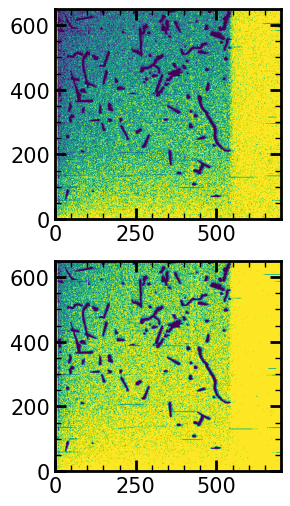

In [40]:

fig=plt.figure(figsize=(10,6))


label_0=ndimage.label(data[0]>1,structure=[[1,1,1],[1,1,1],[1,1,1]])[0]
plt.subplot(2,1,1)
plt.imshow(label_0==0, cmap='viridis', vmax=1,vmin=0)

label_1=ndimage.label(data[0]>2,structure=[[1,1,1],[1,1,1],[1,1,1]])[0]
plt.subplot(2,1,2)
plt.imshow(label_1==0, cmap='viridis', vmax=1,vmin=0)



data=np.array([[1,1,1],[1,1,1],[1,1,1],[1,1,1],[1,1,1]])
data

mask=np.array([[1,0,0],[0,1,0],[0,0,1],[1,0,0],[0,1,0]])
mask

np.where(mask,np.nan,data)

np.s_[2::2]


mask=np.s_[::]  #steps  [start:end:steps], example [::2] = [from first:to end:in steps of]
#https://www.youtube.com/watch?v=PbKOrSottRQ

mask
